## Wavelet entropy in Julia: an introduction

*Note: this is a draft. I guarantee nothing* 

Kristian Agasøster Haaga, 08.12.2021.

In [1]:
using Statistics, Entropies, Plots, Wavelets, LaTeXStrings

We'll start by generating a time series  $f(t), t \in [1, 2, \ldots , N]$, which, for plotting convenience, we limit to $N = 300$ points.

In [2]:
using Entropies, Plots
N, a = 300, 10
t = LinRange(0, 2*a*π, N)
f = sin.(rand(1:15, N) ./ rand(1:10, N));

## Maximal overlap discrete wavelet transform

A discrete wavelet transform is computed by sliding a particular type of wave filter across a time series signal $f(t)$, and seeing how well the filter matches the original signal at a particular point in time. It is computed using $W(\tau, s) = \dfrac{1}{\sqrt{s}} \sum_{t = 0}^{N-1} f(t) \phi \left( \dfrac{t - \tau}{b} \right)$, where $t$ is the time index, $\tau$ is a time-shift parameter (changing $\tau$ will shift the wavelet relative to the original signal), and $s$ governs the width of the wavelet ($s$ large yields wide/expanded wavelets, which match lower frequencies better; $s$ small yields narrow/shrunken wavelets which match higher frequencies better). The value $W(\tau, s)$ indicates how well the signal, at a particular time $\tau$, matches the wavelet whose width is $s$.

If $\tau = k 2^{-j}$ and $s = 2^{-j}$, we call the scales *dyadic scales*. Using dyadic scales requires relatively few computations to calculate wavelet coefficients $W(\tau, s)$. In constrast, if we wanted a continuous wavelet transform, computations would be more expensive, because we would need to compute the transform for a continous set of scaler and time-shifts (or, rather, with *small enough* steps, when using a computer).

To illustrate how wavelet entropy is computed, we'll first compute the detail coefficients for a maximal overlap discrete wavelet transform (MODWT), which assumes circular boundary conditions, so that there are $J$ coefficients for each time $t$. We will obtain a matrix $W_{t,s}$ with $N$ rows and $n_{scales}$ columns. Each row in $W$ contains the wavelet coefficients at time $t$ for scales $J = 1, 2, \ldots, n_{scales}$. There are `n_scales = Wavelets.WT.maxmodwttransformlevels(f) = floor(Int, log2(length(f))) = floor(Int, log2(N))` possible scales for our signal $f(t)$, and the number of scales will vary with signal length. 

In [3]:
Wavelets.WT.maxmodwttransformlevels(f), floor(Int, log2(N))

(8, 8)

There are many possible choices of the wavelet function $\phi(\tau, s)$. Here, we'll pick the Haar wavelet, because it has the property of additive decomposition (Percival & Walden, 2000, p. 205), which means that we can reconstruct the original time series from the wavelet coefficients.

In [4]:
wl = Wavelets.WT.Haar()
W = Entropies.get_modwt(f, wl)

300×8 Matrix{Float64}:
 -0.805327   -0.416259    -0.0829205   …  -0.131756     0.0031218    0.482128
  0.964449   -0.402066     0.0295453      -0.142343     0.0153024    0.483365
 -0.352182    0.385695    -0.0777045      -0.157074     0.0275814    0.48007
  0.0919527   0.176019    -0.174326       -0.151768     0.0356763    0.477241
  0.12183    -0.0232232    0.165954       -0.133985     0.0282119    0.481788
  0.136161    0.235887     0.0929296   …  -0.0876612    0.0235376    0.488012
 -0.269068    0.0625423    0.200895       -0.09568      0.0191324    0.483977
  0.251183   -0.0753957    0.286199       -0.0404836    0.0189502    0.488918
 -0.187271    0.0230138    0.0624376      -0.0287558    0.0124681    0.489077
 -0.168847   -0.146102    -0.0305034      -0.0338128    0.00191506   0.489288
  0.330947   -0.0970086    0.00578065  …   0.0194427    0.000195283  0.489818
  0.0373443   0.265196    -0.0512026       0.0309431   -0.0114105    0.501971
 -0.409045   -0.00170483  -0.0863541      

Because of the property of additive decomposition, we can write $\mathbf{x} = \sum_{i=1}^{n_{scales}} \mathbf{W_i}$ (here $\mathbf{x}$ and $\mathbf{W_i}$ are column vectors, and $\mathbf{W_i}$ contain the coefficients at scale $i$). A single time series value at time $k$ can thus be reconstructed $\sum_{i = 1}^{n_{scales}} W_{k,i}$. Let's verify that our original signal and wavelet-reconstructed signal are equal (within some tolerance, due to imprecisions introduced during calculations):

In [5]:
reconstructed = [sum(W[t, :]) for t = 1:N]

all(f .- reconstructed .< 1e-10)

true

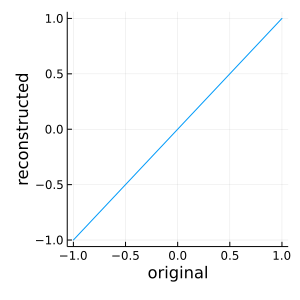

In [6]:
plot(f, reconstructed, size = (300, 300), label = "", xlabel = "original", ylabel = "reconstructed")

## Relation between original time series and coefficients

The detail coefficients at successive levels are the parts of the signals left by passing the original signal through successive low-pass filters, such that the coefficients at level $j$ contains the part of the time series whose frequencies did not pass further down the cascade of low-pass filters. The coefficients at dyadic scale $j$ corresponds to a frequency range $\big(\dfrac{1}{2^{j+1}}, \dfrac{1}{2^{j}}\big]$. Let's visualize this:

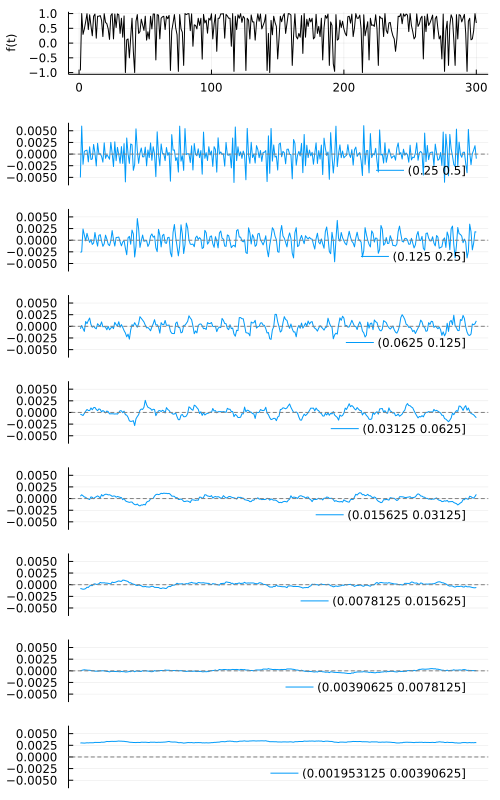

In [7]:
# Normalize coefficients to total energy to have the same axis scales, see below
Etot = sum(W .^ 2)
emax = maximum(W ./ Etot)*1.1

# Plot the coefficients for each dyadic scale j, corresponding to frequency range (1/2^(j+1), 1/2^j].
ps = Plots.Plot[]
for j = 1:size(W, 2)
    ylbl = "s_$j"
    lbl = string("(", 1/2^(j+1), " ", 1/2^j, "]")
    push!(ps, plot(W[:, j] ./ Etot, 
                    fg_legend = :transparent, bg_legend = :transparent, legend = :bottomright,
                    xticks = false, xaxis = false,
                    ylabel = latexstring(ylbl), label = lbl, ylim = (-emax, emax)))
    hline!([0], ls = :dash, label = "", lq = 0.8, c = :grey)
end

# Merge original plot and coefficient plots.
p_ts = plot(f, ylabel = "f(t)", xlabel = "t", c = :black, label = "")
p_wl = plot(p_ts, ps..., link = :x, layout = grid(length(ps)+1, 1), guidefont = font(8), size = (500, 800), xlabel = "")

For our example time series, we can see that most of the variability is located at intermediate-high frequencies.

## Relative signal energy and wavelet entropy

The [*energy*](https://en.wikipedia.org/wiki/Energy_(signal_processing)) of the signal at a particular scale level (frequency range) $j$ is $E_j = \sum_{t=1}^{N} (W_{tj})^2$. The total energy of the signal is $E_{tot} = \sum_{t=1}^{N}\sum_{j = 1}^{n_{scales}} (W_{t,j})^2$. Based on the quantities $E_j$ and $E_{tot}$, we can define the *relative energy* at each frequency range $\big(\dfrac{1}{2^{j+1}}, \dfrac{1}{2^{j}}\big]$ as $p_j = \dfrac{E_j}{E_{tot}}$.
The relative energy at level $j$ thus gives an indication of strongly that frequency range is present in the original signal. Normalizing each $p_j$ to the total energy, this naturally gives rise of the notion of a *probability distribution over the frequency bands corresponding to each dyadic levels*.  

In [8]:
ρs = [Entropies.energy_at_scale(W, j) ./ Etot for j = 1:size(W, 2)]

8-element Vector{Float64}:
 0.2738045207764152
 0.11935778797910458
 0.053979061628271575
 0.032981485968457264
 0.015640601580414436
 0.0073874016856513465
 0.002526898148804093
 0.49432224223288157

Computing entropy from `ρs` is of course trivial:

In [9]:
Entropies.genentropy(Probabilities(ρs), base = 2)

1.9377788046525701

Entropy is maximized for a uniform probability distribution, and is always lower for non-flat distributions.

In [10]:
genentropy(Probabilities([0.2, 0.2, 0.2, 0.2, 0.2]), base = 2), genentropy(Probabilities([0.1, 0.2, 0.3, 0.2, 0.2]), base = 2)

(2.321928094887362, 2.2464393446710154)

Similarly, the wavelet entropy is maximized when energy is spread out across all frequency bands. The following three signals illustrate this nicely.

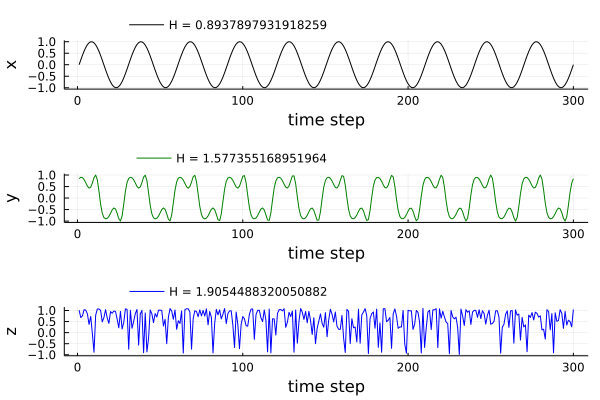

In [11]:
x = sin.(t);
y = sin.(t .+  cos.(t/0.5));
z = sin.(rand(1:15, N) ./ rand(1:10, N)) .+ rand(N)*0.1

est = TimeScaleMODWT()
h_x = Entropies.genentropy(x, est, base = 2)
h_y = Entropies.genentropy(y, est, base = 2)
h_z = Entropies.genentropy(z, est, base = 2)

px = plot(x, ylabel = "x", c = :black, label = "H = $(h_x)")
py = plot(y, ylabel = "y", c = :green, label = "H = $(h_y)")
pz = plot(z, ylabel = "z", c = :blue, label = "H = $(h_z)")

# Get coefficients, then compute relative energies corresponding to 
# different frequency bands.
wl = Wavelets.WT.Haar()
ρx = Entropies.relative_wavelet_energies(Entropies.get_modwt(x, wl))
ρy = Entropies.relative_wavelet_energies(Entropies.get_modwt(y, wl))
ρz = Entropies.relative_wavelet_energies(Entropies.get_modwt(z, wl))
# Or Entropies.time_scale_density(ts, wl) directly

plot(px, py, pz, layout = grid(3, 1), xlabel = "time step", 
    legend = :outertop, fg_legend = :transparent, bg_legend = :transparent)

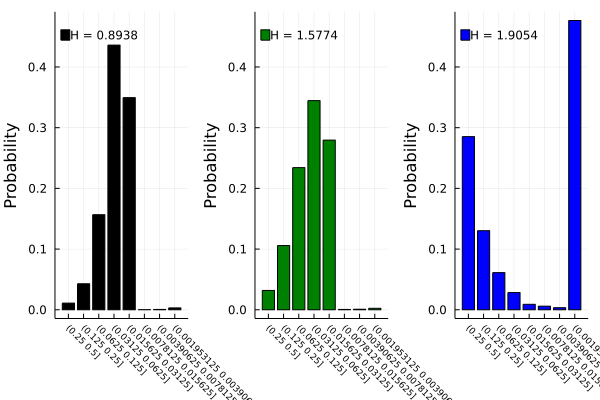

In [12]:
frequency_bands = [string("(", 1/2^(j+1), " ", 1/2^j, "]") for j = 1:length(ρx)]
distx = bar(ρx, c = :black, ylabel = "Probability", xticks = (1:length(ρx), frequency_bands), xrotation =-45, xtickfont = font(6), label = "H = $(round(h_x, digits = 4))")
disty = bar(ρy, c = :green, ylabel = "Probability", xticks = (1:length(ρx), frequency_bands), xrotation =-45, xtickfont = font(6), label = "H = $(round(h_y, digits = 4))")
distz = bar(ρz, c = :blue, ylabel = "Probability", xticks = (1:length(ρx), frequency_bands), xrotation =-45, xtickfont = font(6), label = "H = $(round(h_z, digits = 4))")
plot(distx, disty, distz, layout = grid(1, 3), link = :y, legend = :topleft, fg_legend = :transparent, bg_legend = :transparent)

The time series with the widest range of frequencies (`z`) has the highest wavelet entropy, while the smoothest time series (`x`) which has most of its energy at few frequency bands has the lowest wavelet entropy.